In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
import numpy as np
from tensorflow.python.keras import models
from scipy.optimize import fmin_l_bfgs_b

from IPython import display
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, BatchNormalization, Dropout,Add

## Reshape Image

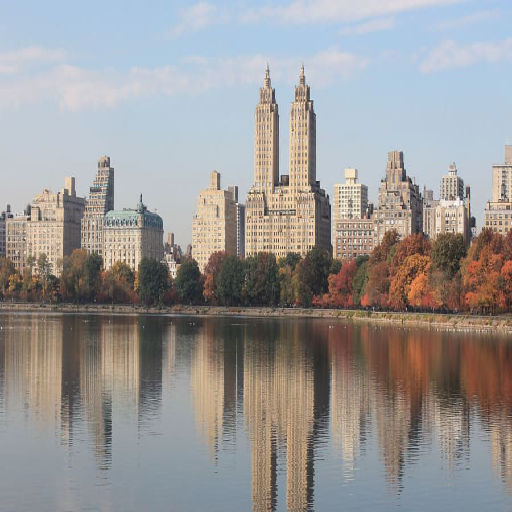

In [0]:
height = 512
width  = 512

content_image_path = 'central_park.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

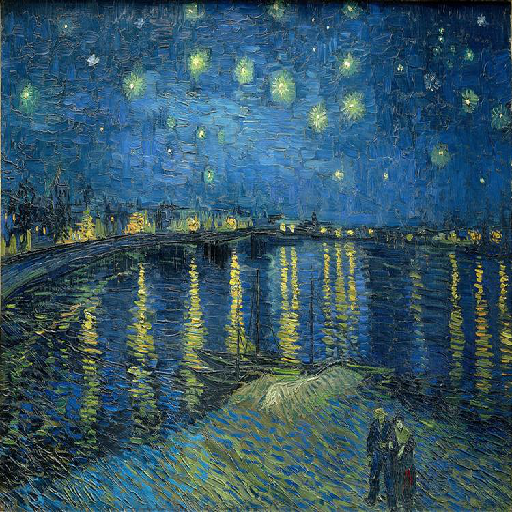

In [0]:
style_image_path = 'starry_night.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

In [0]:
content_array = np.asarray(content_image, dtype='float32')
style_array   = np.asarray(style_image, dtype='float32')
print(content_array.shape)
print(style_array.shape)

(512, 512, 3)
(512, 512, 3)


In [0]:
content_array = np.expand_dims(content_array, axis=0)
style_array   = np.expand_dims(style_array, axis=0)
print(content_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [0]:
content_array=tf.keras.applications.vgg16.preprocess_input(content_array)

In [0]:
style_array=tf.keras.applications.vgg16.preprocess_input(style_array)

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(content_array).shuffle(1).batch(1).prefetch(1)

## Model 1: Transform Net

In [0]:
class TransformNet(tf.keras.Model):
  def __init__(self):
    super(TransformNet, self).__init__()
    # encode block
    self.block1_conv1 = Conv2D(filters=32, kernel_size=(9,9), strides=1, padding="same")
    self.block1_batchnorm1 = BatchNormalization()
    self.block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=2, padding="same")
    self.block1_batchnorm2 = BatchNormalization()
    self.block1_conv3 = Conv2D(filters=128, kernel_size=(3,3), strides=2, padding="same")
    self.block1_batchnorm3 = BatchNormalization()
    # residual net block
    self.block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm1 = BatchNormalization()
    self.block2_add1 = Add()
    self.block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm2 = BatchNormalization()
    self.block2_add2 = Add()
    self.block2_conv3 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm3 = BatchNormalization()
    self.block2_add3 = Add()
    self.block2_conv4 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm4 = BatchNormalization()
    self.block2_add4 = Add()
    self.block2_conv5 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm5 = BatchNormalization()
    self.block2_add5 = Add()
    # decode block
    self.block3_conv1transpose = Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, padding="same")
    self.block3_batchnorm1 = BatchNormalization()
    self.block3_conv2transpose = Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, padding="same")
    self.block3_batchnorm2 = BatchNormalization()
    self.block3_conv3transpose = Conv2D(filters=3, kernel_size=(9,9), strides=1, padding="same")
    self.block3_batchnorm3 = BatchNormalization()
    
  def call(self, x, training=True):
    # encode block
    #x = tf.reshape(x,(-1,512,512,3))
    #x /= 255
    #x = x[0,:,:,:]
    #x -=[0.485, 0.456, 0.406]
    #x /=[0.229, 0.224, 0.225]
    #x = tf.keras.applications.vgg16.preprocess_input(x)
    x = tf.reshape(x,(-1,512,512,3))
    x = self.block1_conv1(x)
    x = self.block1_batchnorm1(x, training=training)
    x = tf.nn.relu(x)
    x = self.block1_conv2(x)
    x = self.block1_batchnorm2(x, training=training)
    x = tf.nn.relu(x)
    x = self.block1_conv3(x)
    x = self.block1_batchnorm3(x, training=training)
    x = tf.nn.relu(x)
    # residual block
    x1 = x
    x = self.block2_conv1(x)
    x = self.block2_batchnorm1(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_add1([x, x1])
    x1 = x
    x = self.block2_conv2(x)
    x = self.block2_batchnorm2(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_add2([x, x1])
    x1 = x
    x = self.block2_conv3(x)
    x = self.block2_batchnorm3(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_add3([x, x1])
    x1 = x
    x = self.block2_conv4(x)
    x = self.block2_batchnorm4(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_add4([x, x1])
    x1 = x
    x = self.block2_conv5(x)
    x = self.block2_batchnorm5(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_add5([x, x1])
    
    # decode block
    x = self.block3_conv1transpose(x)
    x = self.block3_batchnorm1(x,training=training)
    x = tf.nn.relu(x)
    x = self.block3_conv2transpose(x)
    x = self.block3_batchnorm2(x,training=training)
    x = tf.nn.relu(x)
    x = self.block3_conv3transpose(x)
    x = self.block3_batchnorm3(x,training=training)
    x = tf.nn.relu(x)
    #x = x[0,:,:,:]
    #x *= [0.229, 0.224, 0.225]
    #x += [0.485, 0.456, 0.406]
    #x *= 255
    #x = tf.clip_by_value(x,0,255)
    #x = tf.reshape(x,(-1,512,512,3))
    return x

## Model 2: VGG16

In [0]:
class VGG16_Model(tf.keras.Model):
  def __init__(self):
    super(VGG16_Model, self).__init__()
    # encode block
    self.vgg16 = tf.keras.applications.vgg16.VGG16(input_shape=(512, 512, 3), include_top=False)
  
  def call(self, x, training=True):
    self.vgg16.trainable=False
    #x = tf.keras.applications.vgg16.preprocess_input(x[0,:,:,:])
    content_outputs=[self.vgg16.get_layer(l).output for l in layers_content]
    style_outputs=[self.vgg16.get_layer(l).output for l in layers_style]
    outputs=content_outputs+style_outputs
    model=models.Model(self.vgg16.input,outputs)
    #x = np.expand_dims(x,axis=0)
    x = model(x)
    return x

In [0]:
transform_net= TransformNet()
vgg16 = VGG16_Model()

## Compute Loss

In [0]:
def content_loss(y_hat_features,content_features):
  """This function will compute content loss
  
  Arguments:
    y_hat_features: combination image features
    content_features: content image features
      
  Returns:
    returns content loss
  """
  return tf.reduce_sum(tf.square(y_hat_features-content_features))

In [0]:
def gram_matrix(feature_tensor):
  """This function will compute gram matrix based on Gatys paper
  
  Arguments:
    feature_tensor: feature tensor
      
  Returns:
    returns gram matrix
  
  Note:
    In order to reduce computation somehow, we could normalize loss. 
    This idea comes from tensorflow tutorial:
    https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb
  
  """
  channel = int(feature_tensor.shape[-1])
  feature_2d=feature_tensor[0,:,:,:]
  #feature_2d=tf.keras.backend.permute_dimensions(feature_2d,(2,0,1))
  feature_2d=tf.reshape(feature_tensor, [-1, channel])
  #n=feature_2d.shape[0]
  feature_2d=tf.matmul(feature_2d, feature_2d, transpose_a=True)
  #return feature_2d/tf.cast(n,tf.float32)
  return feature_2d

In [0]:
def style_loss_per_layer(y_hat_features,style_features):
  """This function will compute style loss for a specific layer
  
  Arguments:
    y_hat_features: combination image features
    style_features: style image features
      
  Returns:
    returns style loss for each layer
  
  """
  y_hat_gram=gram_matrix(y_hat_features)
  style_gram=gram_matrix(style_features)
  _,h,w,N,=style_features.shape
  #M=tf.multiply(h,w).numpy()
  M=tf.cast(tf.multiply(h,w),tf.float32)
  N=tf.cast(N,tf.float32)
  #M2=tf.pow(tf.cast(M,tf.float32),2)
  #N2=tf.pow(tf.cast(N,tf.float32),2)
  norm=tf.divide(1,tf.multiply(M,N))
  style_l=tf.reduce_sum(tf.square(style_gram-y_hat_gram))
  return tf.multiply(norm,style_l)
  #return style_l

In [0]:
def style_loss(y_hat_features_lst,style_features_lst):
  """This function will compute total style loss
  
  Arguments:
    y_hat_features_lst: combination image features for many layers
    style_features_lst: style image features for many layers
      
  Returns:
    returns total style loss
  
  """
  style_score=0
  style_weight_per_layer=1.0/float(len(style_features_lst))  #uniformly
  for i in range(len(style_features_lst)):
    style_loss_single=style_loss_per_layer(y_hat_features_lst[i],style_features_lst[i])
    style_score += style_weight_per_layer * style_loss_single
  return style_score

In [0]:
def variation_loss(y_hat,height,width,beta):
  """This function will compute variation loss
  
  Arguments:
    y_hat: combination image 
    height: image height
    width: image width
      
  Returns:
    returns variation loss
  
  Note: variation loss is a regularisation term that encourages spatial smoothness.
        this idea comes from this paper: https://arxiv.org/abs/1412.0035
  
  """
  a = tf.square(y_hat[:, :height-1, :width-1, :] - y_hat[:, 1:, :width-1, :])   
  b = tf.square(y_hat[:, :height-1, :width-1, :] - y_hat[:, :height-1, 1:, :])
  return tf.reduce_sum(tf.pow(a + b, beta/2))

In [0]:
def compute_loss(model,y_hat,content_image,style_image,
                 content_weight,style_weight,variation_weight,beta):
  
  """This function will compute total loss
  
  Arguments:
    model: the hidden model we build
    y_hat: the image generated from transform net
    content_image: content image(numpy array)
    style_image: style image(numpy array)
    content_weight, style_weight, variation_weight: weights
    beta: beta parameter for variation loss
      
  Returns:
    returns total loss
  
  """
  content_features=model(content_image)[0]
  style_features_lst=model(style_image)[1:]
  y_hat_features=model(y_hat)
  loss_c=content_loss(y_hat_features[0],content_features)
  loss_s=style_loss(y_hat_features[1:],style_features_lst)
  loss_var=variation_loss(y_hat,height,width,beta)
  l=content_weight*loss_c+style_weight*loss_s+variation_weight*loss_var
  return l
  #return content_weight*loss_c+style_weight*loss_s

In [0]:
opt = tf.train.AdamOptimizer(learning_rate=1e-3)

In [0]:
epochs = 500

In [0]:
content_weight=0.025
style_weight=0.1
variation_weight=1
beta=2.5

layers_content = ['block2_conv2']
layers_style = ['block1_conv2', 'block2_conv2','block3_conv3', 'block4_conv3','block5_conv3']

In [0]:
def train_step(model,content_image,style_image):
  
  with tf.GradientTape() as tape:
    
    # Generate y_hat from transform_net
    y_hat = transform_net(content_image, training=True)
    total_loss=compute_loss(model,y_hat,content_image,style_image,
                            content_weight,style_weight,variation_weight,beta)

  grads = tape.gradient(total_loss, transform_net.variables)

  opt.apply_gradients(zip(grads, transform_net.variables))
  return total_loss

In [0]:
# Compile the training step with defun for increased performance.
# Comment out this line for easier debugging.
train_step = tf.contrib.eager.defun(train_step)

In [0]:
tfe = tf.contrib.eager

In [0]:
means=[103.939, 116.779,123.68]

In [0]:
def generate_and_display():
  display.clear_output(wait=True)
  y_hat = transform_net(content_array,training=False)
  y_hat = y_hat.numpy()[0,:,:,:]+means
  y_hat = y_hat[:, :,::-1]
  y_hat = np.clip(y_hat,0,255).astype('uint8')
  fig = plt.figure(figsize=(4,4))
  plt.imshow(y_hat)
  plt.axis('off')
  plt.show()  

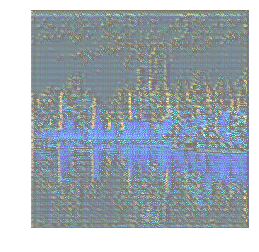

Epoch 499. Seconds 1.004201889038086
Epoch 499. Loss 1203732230438912.0


In [0]:
for epoch in range(epochs):
  start = time.time()
  l_t=train_step(vgg16,content_array,style_array)
  #opt = tf.contrib.opt.ScipyOptimizerInterface(l_t)

  end = time.time()
  generate_and_display()
  print ('Epoch {}. Seconds {}'.format(epoch, end - start))
  print ('Epoch {}. Loss {}'.format(epoch,l_t))

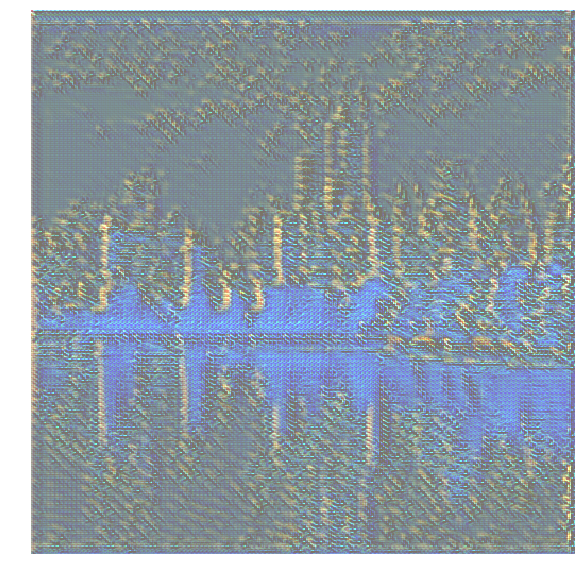

In [0]:
result_img=transform_net(content_array,training=False)
result_img=result_img.numpy()[0,:,:,:]+means
result_img=result_img[:,:,::-1]
plt.figure(figsize=(10,10))
plt.imshow(np.clip(result_img,0,255).astype('uint8'))
plt.grid(False)
plt.axis('off')
plt.savefig("content_beta.png",bbox_inches='tight')